In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# read the dataset
file_path = 'WEEE Collected in the Uk.xlsx'
def date_parser(year):
    return pd.to_datetime(str(year), format='%Y')
try:
    df = pd.read_excel(file_path,parse_dates=['Date'], index_col='Date')
    print(df.head())
except Exception as e:
    print("Error:", e)

                Total
Date                 
2008-01-01  430177.59
2009-01-01  469126.09
2010-01-01  478862.72
2011-01-01  517142.88
2012-01-01  504787.30


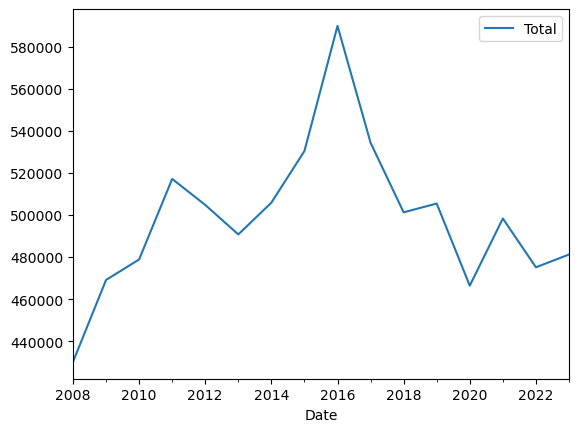

In [7]:
# visualize the dataset
df.plot()
plt.show()

In [8]:
import statsmodels.api as sm

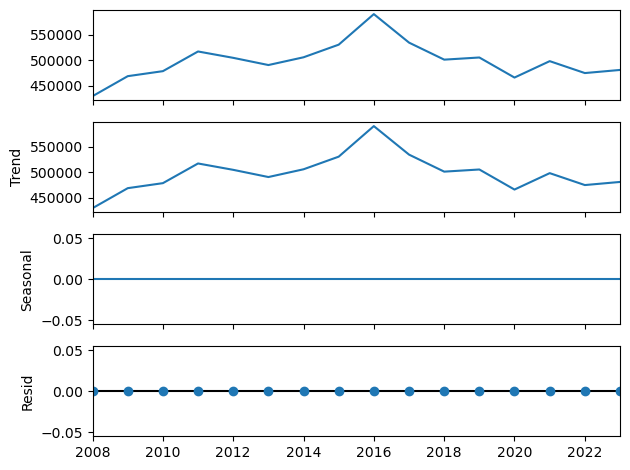

In [9]:
# decompose data to check for seasonality and trend
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
# check the pvalue of dateset to determine stationarity
adfest = adfuller(df['Total'])

print('p value of adfuller test is', adfest[1])

p value of adfuller test is 0.4792724311625144


In [12]:
from pmdarima import auto_arima
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [121]:
# using the auto_arima function to determine pdq values
auto_arima = auto_arima(df, trace=True, suppress_warnings=True)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=384.991, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=383.721, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=381.274, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=382.322, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=467.314, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=382.792, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=382.702, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=383.692, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.671 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   16
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -187.637
Date:                Fri, 26 Apr 2024   AIC                            381.274
Time:                        20:02:23   BIC                            383.591
Sample:                    01-01-2008   HQIC                           381.392
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.659e+05    9.8e+04      2.714      0.007    7.39e+04    4.58e+05
ar.L1          0.4627      0.196      2.359      0.018       0.078       0.847
sigma2      6.518e+08     64.893      1e+07      0.000    6.52e+08    6.52e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.04
Prob(Q):                              0.84   Prob(JB):                         0.36
Heteroskedasticity (H):               0.46   Skew:                             0.56
Prob(H) (two-sided):                  0.41   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+22. Standard errors may be unstable.
"""

In [97]:
from statsmodels.tsa.arima.model import ARIMA

# divide data into training and test sets
train = df[:13]
test = df[13:]

In [98]:
# use itertools to determine the range
import itertools

p = range(0,8)
q = range(0,8)
d = range(0,2)

pdq_combination = list(itertools.product(p,d,q))

len(pdq_combination)

128

In [108]:
rmse=[]
order1=[]

In [109]:
#  iterate to get the pdq combination with the least rmse and append to a list.
from sklearn.metrics import mean_squared_error
for pdq in pdq_combination:
    try:
        model= ARIMA(train,order = pdq).fit()
        pred = model.predict(start=len(train), end=(len(df)-1))
        error = np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)

    except Exception as e:
        print(f"Error encountered for {pdq}: {e}")
        continue

In [110]:
results = pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])

In [111]:
# store results in a csv file
results.to_csv('ARIMA_result_recycled_final_1.csv')

In [127]:
# train model for testing
model = ARIMA(train, order=(7,0,4))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   13
Model:                 ARIMA(7, 0, 4)   Log Likelihood                -152.286
Date:                Fri, 26 Apr 2024   AIC                            330.573
Time:                        20:03:00   BIC                            337.917
Sample:                    01-01-2008   HQIC                           329.063
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.019e+05   1.84e+05      2.728      0.006    1.41e+05    8.62e+05
ar.L1          0.3491    223.029      0.002      0.999    -436.780     437.478
ar.L2          0.5944    226.934      0.003      0.9

In [128]:
# make test predictions
start = len(train)
end = len(df)-1
pred = model.predict(start=start, end=end,)
print(pred)

2021-01-01    491509.782663
2022-01-01    481588.611962
2023-01-01    477282.619088
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [129]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

# find the mean sqaured error
error = mean_squared_error(test,pred)
error

34464111.74811831

In [130]:
rmse = np.sqrt(error)
mae = mean_absolute_error(test, pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 5870.614256457182
Mean Absolute Error (MAE): 5729.133403571323


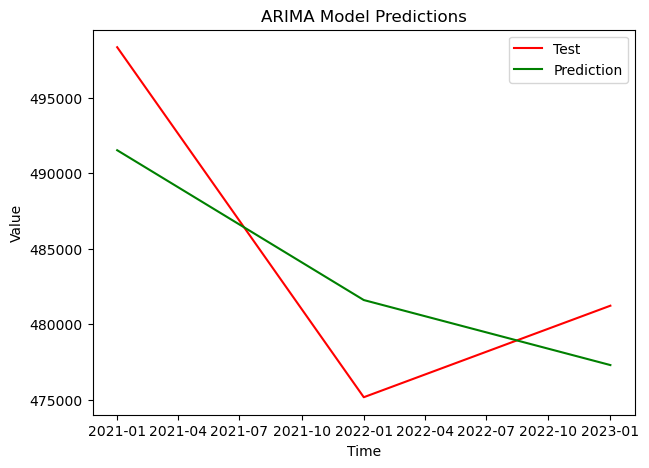

In [131]:
# Plot all data on the same graph
plt.figure(figsize=(7, 5))

# Plot training data
plt.plot(train.index, train.values, label='Train', color='black')

# Plot testing data
plt.plot(test.index, test.values, label='Test', color='red')

# Plot predictions
plt.plot(pred.index, pred.values, label='Prediction', color='green')


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Model Predictions')

plt.legend()

In [132]:
final_model = ARIMA(df,order=(7,0,4)).fit()
prediction = final_model.predict(len(df),len(df)+6)

In [155]:
print(prediction)
file_path = 'arima_recycled_predictions.csv'

# export dates and corresponding prediction values to a CSV file
prediction.to_frame().to_csv(file_path, header=['Predictions'])

2024-01-01    481834.033572
2025-01-01    469005.541036
2026-01-01    499219.924909
2027-01-01    495274.622807
2028-01-01    514474.545357
2029-01-01    515761.497913
2030-01-01    508760.466281
Freq: AS-JAN, Name: predicted_mean, dtype: float64


<Axes: xlabel='Date'>

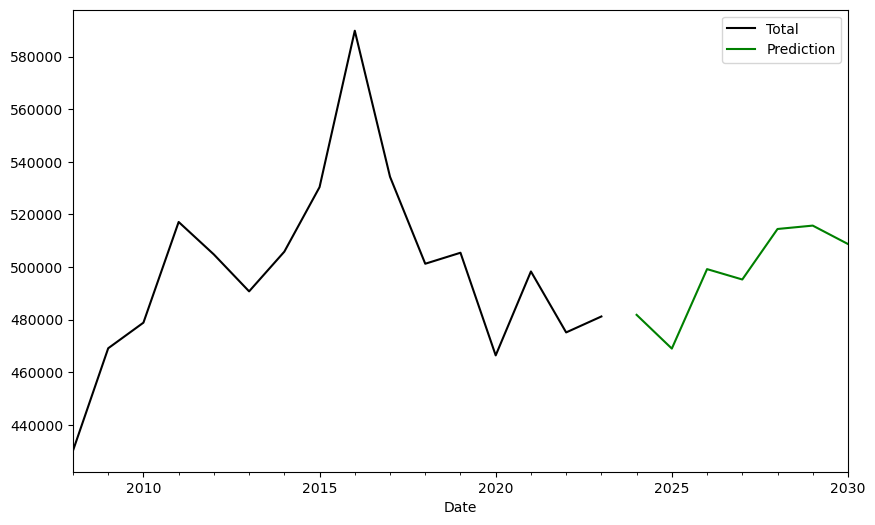

In [134]:
# plot final prediction
df.plot(legend= True, label='Train', figsize=(10,6), color='black')
prediction.plot(legend= True, label='Prediction',  color='green')

In [120]:
# evaluate model using r2 score
from sklearn.metrics import r2_score

r2 = r2_score(test,pred)

print(f'R-squared score: {r2}')

R-squared score: 0.6422048330403833
